## Support vector machines

**Data** [Gender-annoted dataset of European parliament talks](https://www.kaggle.com/ellarabi/europarl-annotated-for-speaker-gender-and-age)

**Overreaching question** Can we develop a model which correctly predicts speakers' gender, based on what they are saying?

## Data management

Let's create a dataset with the variable of interest and the textual data.
The data about gender is stored as XML, so we need to do a bit of work before we can easily use it.
The below code also transforms the text data into a feature matrix.

In [222]:
metadata_all <- readLines('./data/europarl-annotated-for-speaker-gender-and-age/europarl.de-en/europarl.de-en.dat')
texts_all <- readLines('./data/europarl-annotated-for-speaker-gender-and-age/europarl.de-en/europarl.de-en.en.aligned.tok')

set.seed(1) # Set seed for reproducible results

## Processign the data takes some time, so let's choose a random set of 1000 messages to try initial modeling
all_ids <- 1:length( metadata_all )
selected_ids <- sample( all_ids, 1000 )


metadata <- metadata_all[ selected_ids ]
texts <- texts_all[ selected_ids ]

In [223]:
library(XML)

# Parse metadata
clean <- function( entry ){
    xml <- xmlTreeParse( entry )
    return( xmlGetAttr( xml$doc$children$LINE  , "GENDER" ) )
}

gender <- sapply( metadata, FUN = clean )
names( gender ) <- NA

In [224]:
library(quanteda)

corp <- corpus( texts )

token <- tokens( corp, remove_punct=TRUE ) # Remove punctuation

document_terms <- dfm( token )

In [225]:
data <- convert( document_terms, "data.frame" )
data$label_for_ml <- as.vector( gender ) ## adding the variable of interest
data$label_for_ml <- as.factor( data$label_for_ml )

## this column is added when converting to data frame, but it is useless => remove from analysis
data <- data[, -c(1)]

dim( data )

[1] 1000 4046

## Create the train-test split

Used later in the analysis to ensure we do not [overfit](https://en.wikipedia.org/wiki/Overfitting) to the data when training the classifier. Let's use 20% of data for testing.

In [226]:
library( caret )

trainIndex <- createDataPartition(data$label_for_ml, p = .8, list = FALSE)

dataTrain <- data[ trainIndex,]
dataTest  <- data[-trainIndex,]

# Run and evaluate SVM classifier

We now train the model using the **training** data and measure its performance using the **test** dataset.

In [227]:
# This prints a lot of warnings, you can nevermind them
model <- train( label_for_ml ~., data = dataTrain, method = "svmLinear")

print( model )

Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x,

Support Vector Machines with Linear Kernel 

 801 samples
4045 predictors
   2 classes: 'FEMALE', 'MALE' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 801, 801, 801, 801, 801, 801, ... 
Resampling results:

  Accuracy   Kappa       
  0.5456128  -0.002042116

Tuning parameter 'C' was held constant at a value of 1


In [228]:
test_pred <- predict( model, newdata = dataTest )
postResample( test_pred, as.factor(dataTest$label_for_ml) )

Accuracy      Kappa 
 0.5025126 -0.0937101

ROC curve variable importance

  only 20 most important variables shown (out of 4045)

           Importance
commission     100.00
that            73.00
be              68.76
for             58.75
are             56.51
we              56.12
eu              51.63
has             47.98
is              47.06
in              46.73
would           45.37
have            44.17
it              42.78
mr              40.08
the             39.44
to              38.46
there           38.12
parliament      36.90
states          35.34
need            34.88


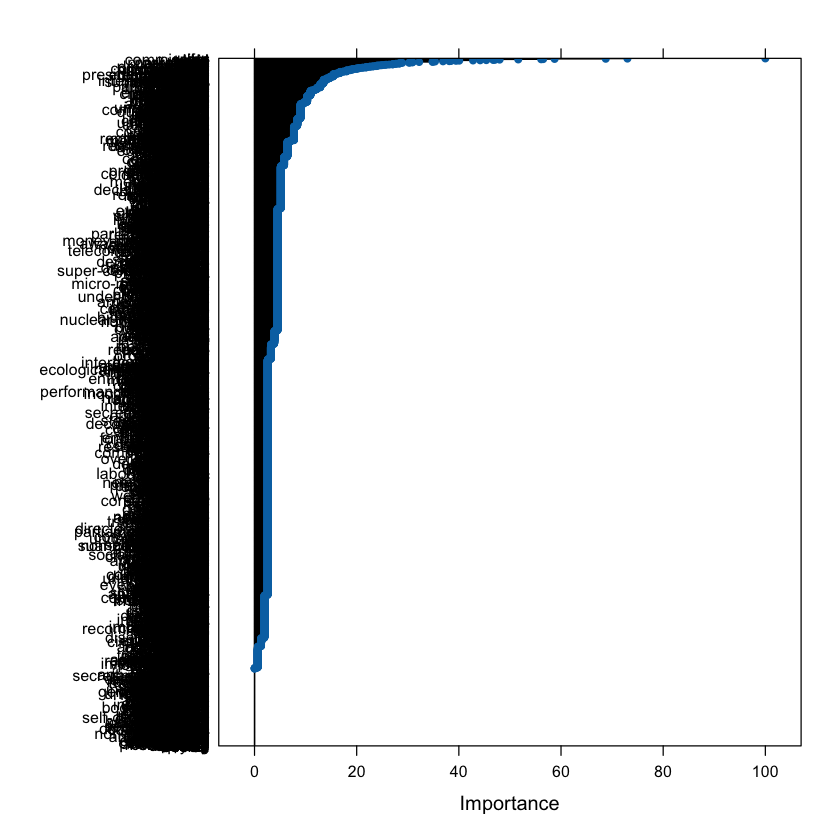

In [229]:
# Check the importance of different words for the predictions
importance <- varImp( model, data = dataTest )

print( importance )
plot( importance )

### Things to try

* Run the above code as is and interprent the accuracy. What does the score mean?
* Examine different metrics for [classification accuracy](https://topepo.github.io/caret/measuring-performance.html).
* Fix issues in the text pre-processing. Account for stop words, frequent terms and stem content in the document-term-matrix. Does this have any infuence on the model's accuracy?
* Predictors include each feature in data (i.e., term), and how important they were in predicting the data. Extract and inspect the best predictor features.
* Modify the code to use [Naive Bayes](https://topepo.github.io/caret/train-models-by-tag.html#bayesian-model) model instead of SVM. Which model seems to work better?

# Advanced magics

* Let's now try to improve the model's performance through *tuning* its parameters.
* [Grid search](https://topepo.github.io/caret/model-training-and-tuning.html#basic-parameter-tuning) is an approach to systematically assess the performance different modeling parameter values.
* You can also work on preprocessing to [scale](https://topepo.github.io/caret/pre-processing.html#centering-and-scaling) the data, or try more acressive cleaning or removal of data.

In [217]:
## Define parameter range for different models
param_grid <- expand.grid( "C" = c(0.1, 1, 10, 100, 1000) )

In [218]:
many_models <- train( label_for_ml ~., data = dataTrain, method = "svmLinear", tuneGrid = param_grid )

Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x,

Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x,

In [219]:
many_models

Support Vector Machines with Linear Kernel 

 801 samples
4045 predictors
   2 classes: 'FEMALE', 'MALE' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 801, 801, 801, 801, 801, 801, ... 
Resampling results across tuning parameters:

  C      Accuracy   Kappa      
  1e-01  0.5591604  -0.01463058
  1e+00  0.5339926  -0.01991129
  1e+01  0.5339086  -0.01869355
  1e+02  0.5339086  -0.01869355
  1e+03  0.5339086  -0.01869355

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was C = 0.1.

In [220]:
pred <- predict( many_models, newdata = dataTest )
postResample( pred, as.factor(dataTest$label_for_ml) )

Accuracy       Kappa 
 0.54773869 -0.08361568

* We have so far used a binary variable (male/female) as target. However, support vector machines can be used to perform multi-category classification or to use linear variables through regression models - see [different models](https://topepo.github.io/caret/available-models.html).

* If doing multi-category classification, the algorithm is senstive to inbalances between classes, i.e. if there are more cases belonging to Category 1 than in Category 2. We might need to do [magic](https://topepo.github.io/caret/subsampling-for-class-imbalances.html) to control for these.

In [221]:
library(ROSE)

# There are some terms in the model that the ROSE package cannot handle (numbers and mathematical expressions).
# These would need to be cleaned out before running the below code.
# Let's now use a subset of the training data to demonstrate the idea.

dataTrainSub <- dataTrain[c(1:5,7:13,15:38,40:91,4046)]

fixedDataTrain <- ROSE( label_for_ml ~ ., data = dataTrainSub) ## note: clean out , before running this code

model <- train( label_for_ml ~., data = fixedDataTrain$data, method = "svmLinear" )
print( model )

Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”
Warning message in .local(x,

Support Vector Machines with Linear Kernel 

801 samples
 88 predictor
  2 classes: 'MALE', 'FEMALE' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 801, 801, 801, 801, 801, 801, ... 
Resampling results:

  Accuracy   Kappa     
  0.5121489  0.02576167

Tuning parameter 'C' was held constant at a value of 1


### Tasks

* Try different grid search parameters, see if the accuracy metric improves.
* Does balancing improve accuracy with the data?
* Use age variable to develop a regression model.